In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
from numpy import linalg as LA

In [2]:

lista_acoes = ["WEGE3", "PCAR3", "PRIO3", "VALE3", "ITUB4"]
lista_acoes = [acao + ".SA" for acao in lista_acoes]

data_final = dt.datetime.now()
data_inicial = data_final - dt.timedelta(days=300)

precos = yf.download(lista_acoes, data_inicial, data_final)['Adj Close']

[*********************100%%**********************]  5 of 5 completed


In [3]:
#Calculando retornos pegando matriz de covariância

retornos = precos.pct_change().dropna()
media_retornos = retornos.mean()
matriz_covariancia = retornos.cov()
pesos_carteira = np.full(len(lista_acoes), 1/len(lista_acoes))
numero_acoes = len(lista_acoes)

pesos_carteira

array([0.2, 0.2, 0.2, 0.2, 0.2])

# Fórmula retornos sintéticos
---
Retornos_sintéticos = média_retornos + Rpdf × L.

* média_retornos = Média dos retornos.
* Rpdf = Matriz aleatória gerada por alguma função de densidade de probabilidade.
* L = Matriz triangular inferior proveniente de uma decomposição de Cholesky, usando como base a matriz de covariância dos dados originais.

In [14]:
#Premissas montecarlo

numero_simulacoes = 10000
dias_projetados = 252
capital_inicial = 1000

In [15]:
#Gerando retorno médio
retorno_medio = retornos.mean(axis = 0).to_numpy()
matriz_retorno_medio = retorno_medio * np.ones(shape = (dias_projetados, numero_acoes))

In [16]:
#Gerando L
L = LA.cholesky(matriz_covariancia)
L

array([[ 1.08833146e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 7.97668491e-03,  4.23112851e-02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 4.47641380e-03,  1.27084593e-03,  1.85961946e-02,
         0.00000000e+00,  0.00000000e+00],
       [ 1.43621594e-03,  1.47501575e-03,  1.67999404e-03,
         1.22668830e-02,  0.00000000e+00],
       [ 1.13061797e-03, -5.58823518e-05,  2.37519029e-03,
         1.75498046e-03,  1.50190446e-02]])

In [17]:
#Gerando simulações

retornos_carteira = np.zeros([dias_projetados, numero_simulacoes]) #Cada coluna é uma simulação
montante_final = np.zeros(numero_simulacoes)

for s in range(numero_simulacoes):

    Rpdf = np.random.normal(size = (dias_projetados, numero_acoes))

    retornos_sinteticos = matriz_retorno_medio + np.inner(Rpdf, L)

    retornos_carteira[:, s] = np.cumprod(np.inner(pesos_carteira,
                                                 retornos_sinteticos) + 1) * capital_inicial
    
    montante_final[s] = retornos_carteira[-1, s]

retornos_carteira

array([[ 984.38994425, 1007.38840717,  987.06628392, ..., 1020.41266653,
         999.59217988, 1016.28564569],
       [ 986.20131909, 1012.61712912,  984.27131052, ..., 1044.84333131,
         999.37232737, 1009.99779124],
       [ 982.40804412, 1007.71988274,  997.04933418, ..., 1040.56382148,
         967.78597237,  998.75446397],
       ...,
       [1209.41737188,  894.84591759, 1355.7400518 , ..., 1301.09457431,
        1037.90063149,  976.80991626],
       [1174.35659578,  909.22243066, 1355.25381192, ..., 1291.13508403,
        1031.77006554,  981.9515915 ],
       [1148.82667555,  878.80352813, 1351.31777761, ..., 1268.83087552,
        1035.54834365,  990.5176856 ]])

<function matplotlib.pyplot.show(close=None, block=None)>

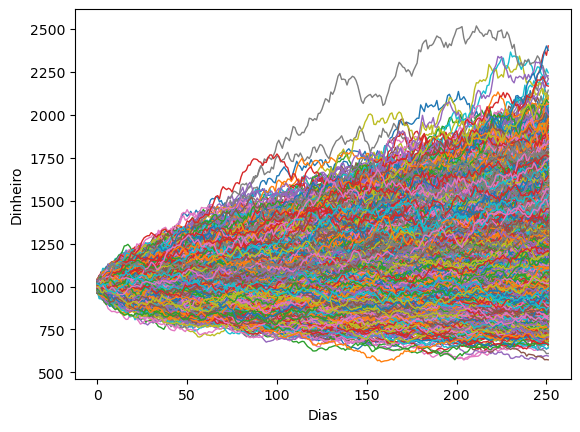

In [18]:
plt.plot(retornos_carteira, linewidth = 1)
plt.ylabel("Dinheiro")
plt.xlabel('Dias')
plt.show

In [23]:
montante_99_confianca = str(np.percentile(montante_final, 1))
montante_95_confianca = str(np.percentile(montante_final, 5))
montante_mediano = str(np.percentile(montante_final, 50))
cenarios_com_lucro = str((len(montante_final[montante_final > 1000])/ len(montante_final)) * 100) + "%"



In [24]:
print(f'''Ao investir R$ 1000,00 na carteira {lista_acoes}, 
podemos esperar esses resultados para os próximo ano, 
utilizando o método de Monte Carlo com 10 mil simulações:

Com 50% de probabilidade, o montante será maior que R$ {montante_mediano}. 

Com 95% de probabilidade, o montante será maior que R$ {montante_95_confianca}.

Com 99% de probabilidade, o montante será maior que R$ {montante_99_confianca}.

Em {cenarios_com_lucro} dos cenários, foi possível obter lucro no próximo ano.''')

Ao investir R$ 1000,00 na carteira ['WEGE3.SA', 'PCAR3.SA', 'PRIO3.SA', 'VALE3.SA', 'ITUB4.SA'], 
podemos esperar esses resultados para os próximo ano, 
utilizando o método de Monte Carlo com 10 mil simulações:

Com 50% de probabilidade, o montante será maior que R$ 1184.9569929195577. 

Com 95% de probabilidade, o montante será maior que R$ 859.3958760486685.

Com 99% de probabilidade, o montante será maior que R$ 752.1168373419209.

Em 81.01% dos cenários, foi possível obter lucro no próximo ano.


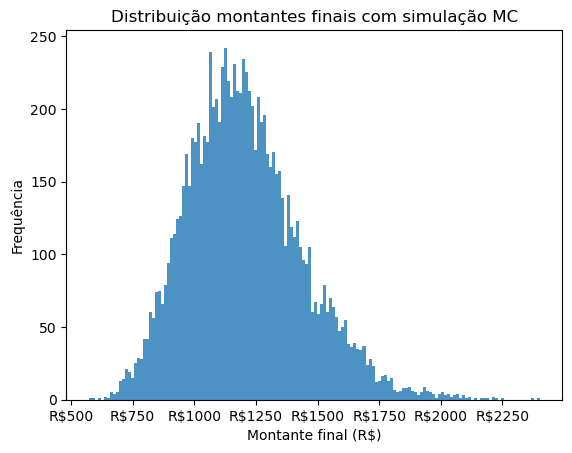

In [22]:
#VaR - Value At Risk

config = dict(histtype = "stepfilled", alpha = 0.8, density = False, bins = 150)
fig, ax = plt.subplots()
ax.hist(montante_final, **config)
ax.xaxis.set_major_formatter('R${x:.0f}')
plt.title('Distribuição montantes finais com simulação MC')
plt.xlabel('Montante final (R$)')
plt.ylabel("Frequência")
plt.show()